# Kotak Playstore Application Reviews Scarping and NLP

In [1]:
import google_play_scraper

import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

import re
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem.wordnet import WordNetLemmatizer

from wordcloud import WordCloud, STOPWORDS,ImageColorGenerator

from transformers import pipeline
sentiment_analysis = pipeline('sentiment-analysis')

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import confusion_matrix,accuracy_score,precision_score,recall_score

No model was supplied, defaulted to distilbert-base-uncased-finetuned-sst-2-english and revision af0f99b (https://huggingface.co/distilbert-base-uncased-finetuned-sst-2-english).
Using a pipeline without specifying a model name and revision in production is not recommended.


In [2]:
from google_play_scraper import reviews,Sort

In [3]:
kotak_app = reviews('com.msf.kbank.mobile',count=1000,sort=Sort.NEWEST)

In [4]:
df_kotak = pd.DataFrame(kotak_app[0])

In [5]:
df_kotak_ = df_kotak[['userName','content','score','reviewCreatedVersion','at']]

In [6]:
df_kotak_

,userName,content,score,reviewCreatedVersion,at
0,Laldhari Yadav,Very slow,3,5.3.8,2022-10-09 12:11:05
1,Amit Rajput,Good,5,5.3.9,2022-10-09 12:07:51
2,Hitesh Mohakar,Not working,1,5.3.8,2022-10-09 12:01:12
3,Partha Roy,Good service,5,5.3.9,2022-10-09 12:00:36
4,Dinesh Baghel bamsoli,Bakwash bank hai ye kotak KYc karake 10 din hu...,1,5.3.8,2022-10-09 11:59:59
...,...,...,...,...,...
995,Tapan Chakraborty,After submitting my all documents showing me t...,1,5.3.8,2022-10-01 18:31:20
996,VINITA SINGH,Noicee..,5,5.3.8,2022-10-01 18:24:39
997,Shishank T,Nice,5,5.3.8,2022-10-01 18:22:20
998,Satyanarayana Nimmanagoti,Good service,5,5.3.8,2022-10-01 18:21:28


### Data Cleaning

In [7]:
filtered_comments=[]

for i in range(0,len(df_kotak_.content)):
    text = df_kotak_.content[i].lower()
    text = re.sub('[^a-zA-Z]',' ',text.strip())
    text = re.sub('\n','',text.strip())
    filtered_comments.append(text.strip())

In [8]:
df_kotak_['filtered_comments'] = filtered_comments

In [9]:
df_kotak_[df_kotak_['filtered_comments']==''].head()

,userName,content,score,reviewCreatedVersion,at,filtered_comments
30,Md Tasleem,ये क्रेडिट कार्ड का सिस्टम भूत आती सुंदर है,5,None,2022-10-09 09:28:37,
47,Chhatrapati Sambhaji Raje building construction,एफ डी क्रेडिट कार्ड घेतले होते पेमेंट साठी ऍडज...,1,5.3.9,2022-10-09 04:10:05,
66,Deepak bari,बहुत ही बढ़िया अनुभव है अन्य बैंकों की अपेक्षा...,5,5.3.9,2022-10-08 21:58:37,
86,sumit SOLANKI,जय श्री राम जय सिया राम,5,5.3.7,2022-10-08 19:03:41,
131,Abdullah Saud,بہترین,5,None,2022-10-08 13:49:27,


In [10]:
df_kotak_.drop(df_kotak_[df_kotak_['filtered_comments']==''].index.tolist(),axis=0,inplace=True)

df_kotak_.reset_index(inplace=True)

df_kotak_.drop(columns=['index'],inplace=True)

In [11]:
count=[]

for i in range(0,len(df_kotak_.filtered_comments)):
    text = len(df_kotak_.filtered_comments[i])
    if text <= 3:
        a=''
    else:
        a=text
    count.append(a)

In [12]:
df_kotak_['num'] = count

df_kotak_[df_kotak_['num']==''].head()

,userName,content,score,reviewCreatedVersion,at,filtered_comments,num
66,M.gopal,90i7550903,5,None,2022-10-08 21:37:51,i,
164,Sabbir Alam,Ok,5,5.3.8,2022-10-08 10:04:20,ok,
201,Deepa Deshmukh,भाऊ हा app खूप च सोलो आहे कोणतेही सिनर लवकर हो...,1,None,2022-10-07 22:25:46,app,
331,Rock Bhai,Dgt,2,None,2022-10-07 07:49:18,dgt,
334,Nawin Chhetri,Wow,5,5.3.8,2022-10-07 07:23:09,wow,


In [13]:
df_kotak_.drop(df_kotak_[df_kotak_['num']==''].index.tolist(),axis=0,inplace=True)

df_kotak_.reset_index(inplace=True)

df_kotak_.drop(columns=['index','num'],inplace=True)

In [14]:
response =[]

for i in range(0,len(df_kotak_.filtered_comments)):
    text = sentiment_analysis(df_kotak_.filtered_comments[i])[0]['label']
    response.append(text)

In [15]:
df_kotak_['response'] = response

In [16]:
#df_kotak_.to_excel("C:\\Users\\Manikanta\\Downloads\\kotak.xlsx")

In [17]:
df_kotak_.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 961 entries, 0 to 960
Data columns (total 7 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   userName              961 non-null    object        
 1   content               961 non-null    object        
 2   score                 961 non-null    int64         
 3   reviewCreatedVersion  824 non-null    object        
 4   at                    961 non-null    datetime64[ns]
 5   filtered_comments     961 non-null    object        
 6   response              961 non-null    object        
dtypes: datetime64[ns](1), int64(1), object(5)
memory usage: 52.7+ KB


In [18]:
df_kotak_.reviewCreatedVersion.replace('None',np.nan,inplace=True)

## Word Cloud

In [19]:
wc = df_kotak_['filtered_comments']

In [20]:
toz_ = [word_tokenize(word) for word in wc]

In [21]:
stop_words =[]

for i in (toz_):
    a=[]
    for j in i:
        if len(j) > 2:
            if not j in stopwords.words('english'):
                a.append(j)
    stop_words.append(a)           

In [22]:
lemm = WordNetLemmatizer()

lemmatize=[]

for i in stop_words:
    for j in i:
        text = ''.join(j)
        lemmatize.append(text)
        text =' '.join(lemmatize)

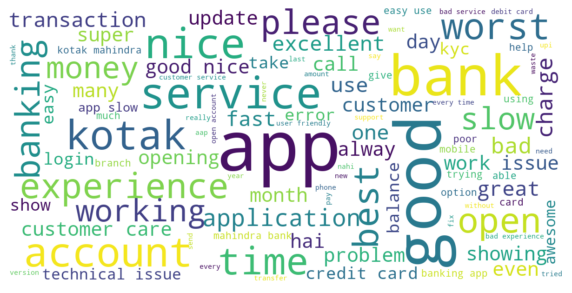

In [23]:
plt.figure(figsize=(10,10))

text = text
stopwords = set(STOPWORDS)
wordcloud = WordCloud(max_font_size=50, max_words=100, background_color="white",scale=3,random_state=0).generate(text)
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off");

## Observations By Insights

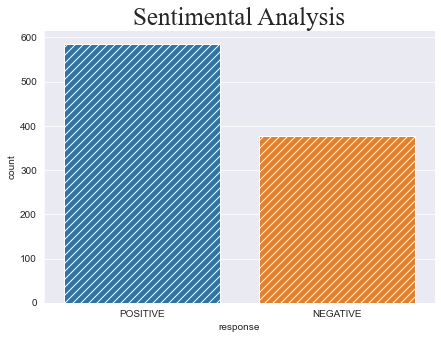

In [24]:
plt.figure(figsize=(7,5))
sns.set_style('darkgrid')

plt.title('Sentimental Analysis',fontdict={'family':'times new roman','size':25})

sns.countplot(x=df_kotak_.response,order=df_kotak_.response.value_counts().index,hatch='///')

sns.despine();

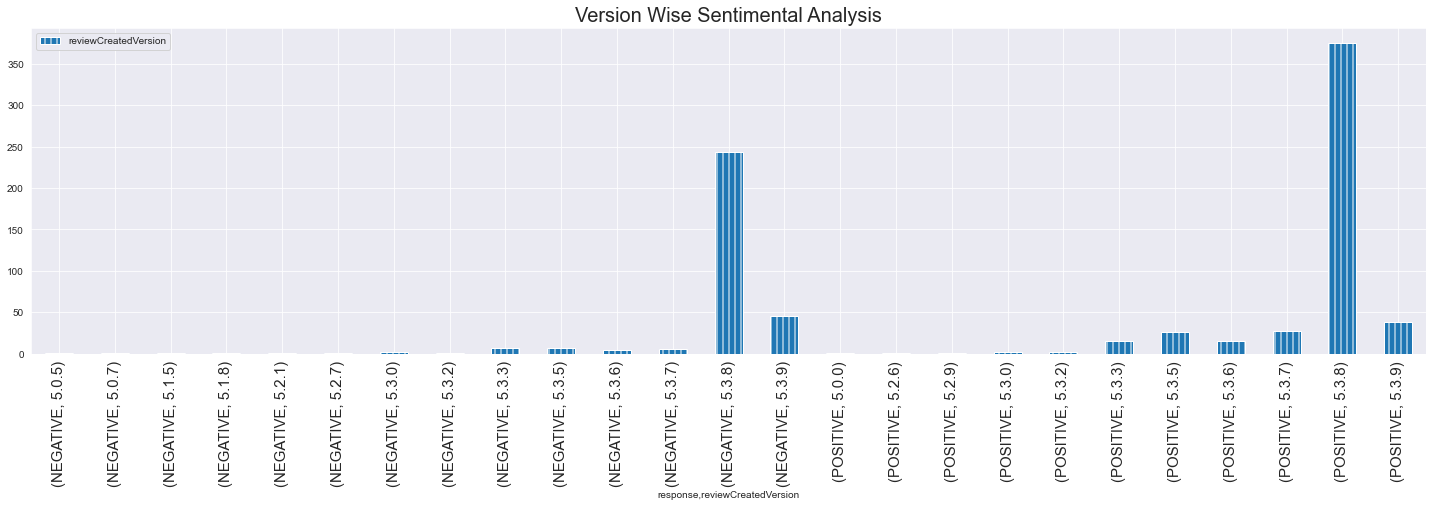

In [25]:
plt.rcParams.update({'figure.figsize':(25,6)})

df_kotak_.groupby(['response','reviewCreatedVersion'])[['reviewCreatedVersion']].count().plot.bar(hatch='||').set_title('Version Wise Sentimental Analysis',fontsize=20)

plt.xticks(fontsize=15);

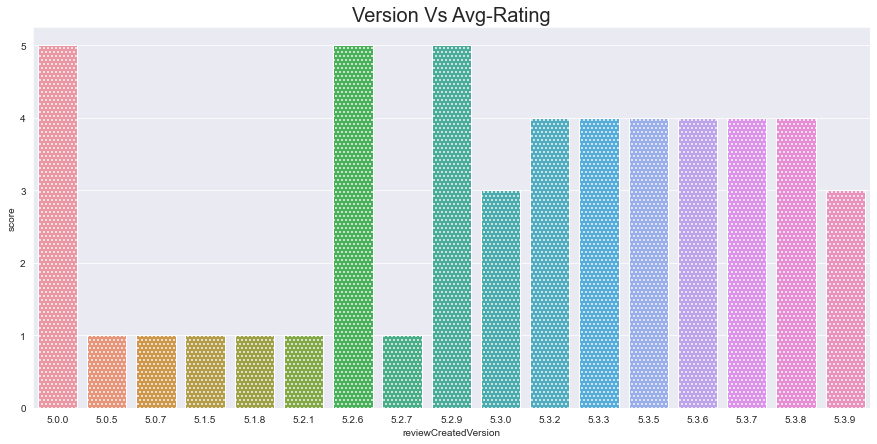

In [26]:
plt.figure(figsize=(15,7))

sample = pd.DataFrame(df_kotak_.groupby('reviewCreatedVersion')['score'].mean().round()).reset_index()
plt.title('Version Vs Avg-Rating',fontsize=20)
sns.barplot(x=sample.reviewCreatedVersion,y=sample.score,hatch='...');

## NLP Model

In [27]:
df_kotak_.head()

,userName,content,score,reviewCreatedVersion,at,filtered_comments,response
0,Laldhari Yadav,Very slow,3,5.3.8,2022-10-09 12:11:05,very slow,NEGATIVE
1,Amit Rajput,Good,5,5.3.9,2022-10-09 12:07:51,good,POSITIVE
2,Hitesh Mohakar,Not working,1,5.3.8,2022-10-09 12:01:12,not working,NEGATIVE
3,Partha Roy,Good service,5,5.3.9,2022-10-09 12:00:36,good service,POSITIVE
4,Dinesh Baghel bamsoli,Bakwash bank hai ye kotak KYc karake 10 din hu...,1,5.3.8,2022-10-09 11:59:59,bakwash bank hai ye kotak kyc karake din hu...,NEGATIVE


In [28]:
x_var = df_kotak_.filtered_comments 
y_var = df_kotak_.response

x_train,x_test,y_train,y_test = train_test_split(x_var,y_var,test_size=0.20,random_state=0)

In [29]:
vec= TfidfVectorizer()
log = LogisticRegression(solver='lbfgs')

model = Pipeline([('vectorizer',vec),('classifier',log)])

model.fit(x_train,y_train)

pred_y = model.predict(x_test)

In [30]:
cf = confusion_matrix(pred_y,y_test)

print(cf)

[[ 75   7]
 [  8 103]]


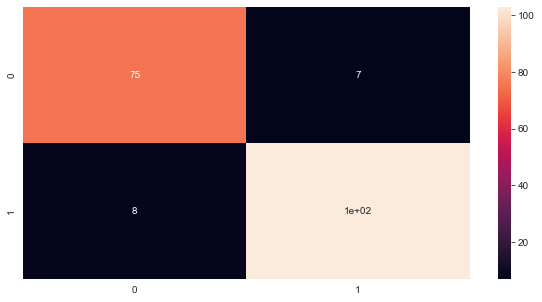

In [31]:
plt.figure(figsize=(10,5))

sns.heatmap(cf,annot=True);

In [32]:
print('\nAccuarcy Score {:.3f}\n'.format(accuracy_score(y_test,pred_y)))

print('Precision Score {:.3f}\n'.format(precision_score(y_test,pred_y,average='weighted')))

print('Recall Score {:.3f}'.format(recall_score(y_test,pred_y,average='weighted')))


Accuarcy Score 0.922

Precision Score 0.922

Recall Score 0.922


In [33]:
comment = ['so many bugs are there some times it is not working quickly']

print(model.predict(comment))

['NEGATIVE']


In [35]:
comment =['it is very easy to operate and i have good experience with the app so far']

print(model.predict(comment))

['POSITIVE']
